In [ ]:
### Grey Scale로 clustering하기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
dataset_path = "C:/Users/jonghui/Downloads/DressCode/cloth/upper_body/"

img_list = []
for img in os.listdir(dataset_path):
    if img.endswith("1.jpg"):
        img_list.append(img)

print(img_list)

['000000_1.jpg', '000001_1.jpg', '000002_1.jpg', '000003_1.jpg', '000004_1.jpg', '000005_1.jpg', '000006_1.jpg', '000007_1.jpg', '000008_1.jpg', '000009_1.jpg', '000010_1.jpg', '000011_1.jpg', '000012_1.jpg', '000013_1.jpg', '000014_1.jpg', '000015_1.jpg', '000016_1.jpg', '000017_1.jpg', '000018_1.jpg', '000019_1.jpg', '000020_1.jpg', '000021_1.jpg', '000022_1.jpg', '000023_1.jpg', '000024_1.jpg', '000025_1.jpg', '000026_1.jpg', '000027_1.jpg', '000028_1.jpg', '000029_1.jpg', '000030_1.jpg', '000031_1.jpg', '000032_1.jpg', '000033_1.jpg', '000034_1.jpg', '000035_1.jpg', '000036_1.jpg', '000037_1.jpg', '000038_1.jpg', '000039_1.jpg', '000040_1.jpg', '000041_1.jpg', '000042_1.jpg', '000043_1.jpg', '000044_1.jpg', '000045_1.jpg', '000046_1.jpg', '000047_1.jpg', '000048_1.jpg', '000049_1.jpg', '000050_1.jpg', '000051_1.jpg', '000052_1.jpg', '000053_1.jpg', '000054_1.jpg', '000055_1.jpg', '000056_1.jpg', '000057_1.jpg', '000058_1.jpg', '000059_1.jpg', '000060_1.jpg', '000061_1.jpg', '000062

In [3]:
print(len(img_list))

15363


In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.images[idx])
        # image = Image.open(img_name).convert('RGB')
        image = Image.open(img_name).convert('L') # load image grey scale
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), # convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomImageDataset(directory=dataset_path, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [6]:
import torch
from torchvision.models import resnet50

# Initialize the pre-trained model
model = resnet50(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Adapt the model to use it as a feature extractor
model = torch.nn.Sequential(*(list(model.children())[:-1]))

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('device: cuda')
else:
    device = torch.device("cpu")
    print('device: cpu')
model = model.to(device)

# Feature extraction function
def extract_features(dataloader, model, device):
    features = []
    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device)  # Move input data to the GPU
            outputs = model(inputs).flatten(start_dim=1)
            features.append(outputs.cpu().numpy())  # Move the tensors back to CPU for numpy conversion
    return np.concatenate(features, axis=0)

# Extract features
features = extract_features(dataloader, model, device)

c:\Users\jonghui\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jonghui\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device: cuda


In [7]:
features.shape

(15363, 2048)

In [8]:
#save model
np.save('./features_grey_image_only.npy', features)

In [9]:
from sklearn.cluster import KMeans

# Clustering
kmeans = KMeans(n_clusters=100, random_state=22)
clusters = kmeans.fit_predict(features)

In [10]:
print(len(clusters))
print(clusters)
print(len(set(clusters)))

15363
[ 3 58 28 ... 76 36 76]
100


In [11]:
cluster_groups = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for i, cluster in enumerate(clusters):
    # print(i, cluster)
    if cluster not in cluster_groups:
        cluster_groups[cluster] = []
    
    cluster_groups[cluster].append(img_list[i])

In [12]:
def print_cluster_img(num):
    for i in range(15):
        img = plt.imread(dataset_path + cluster_groups[num][i])
        plt.subplot(3, 5, i+1)
        plt.axis('off')
        plt.imshow(img)

C:\Users\jonghui\AppData\Local\Temp\ipykernel_17780\1804572213.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


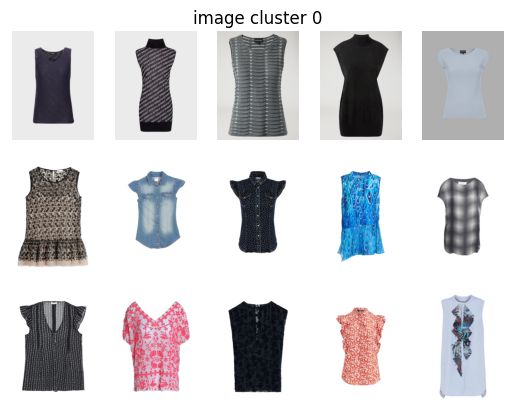

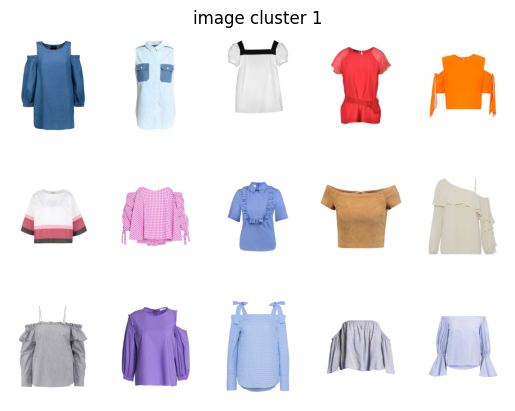

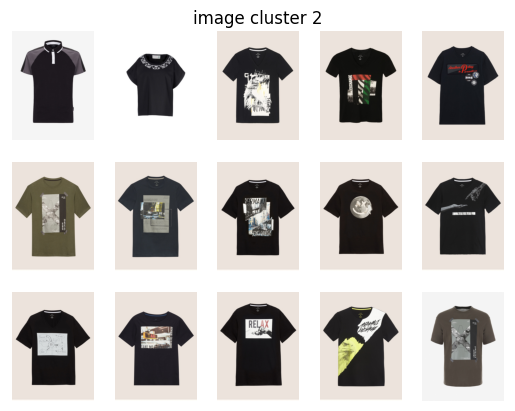

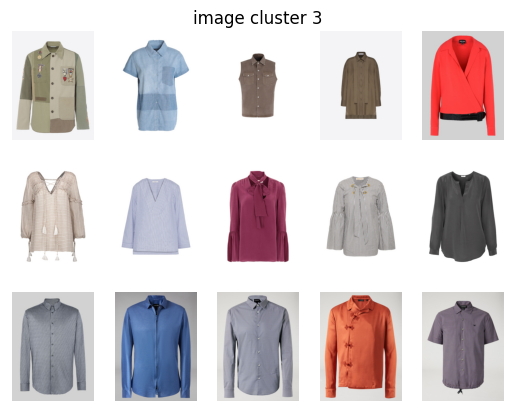

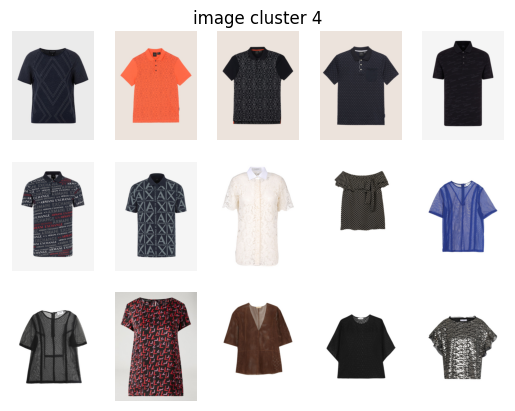

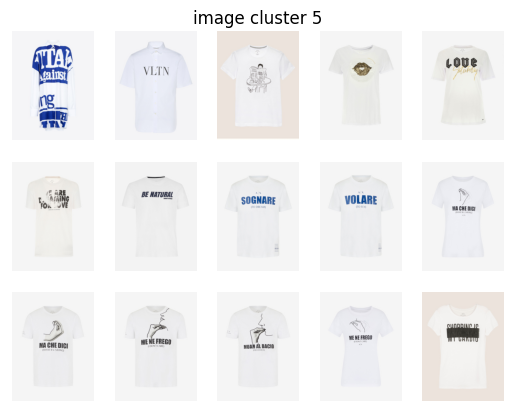

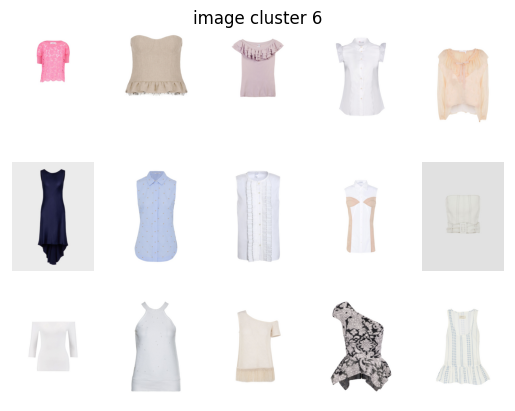

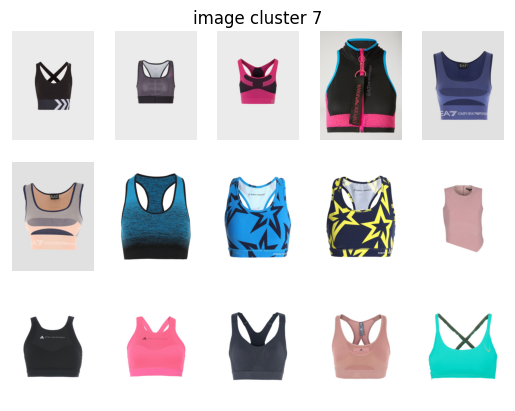

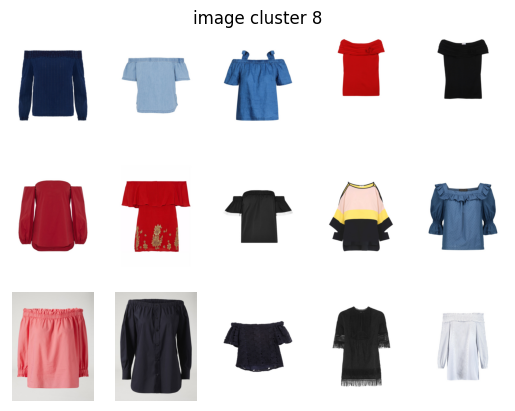

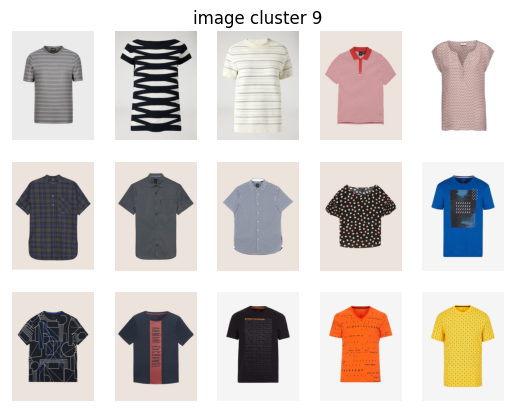

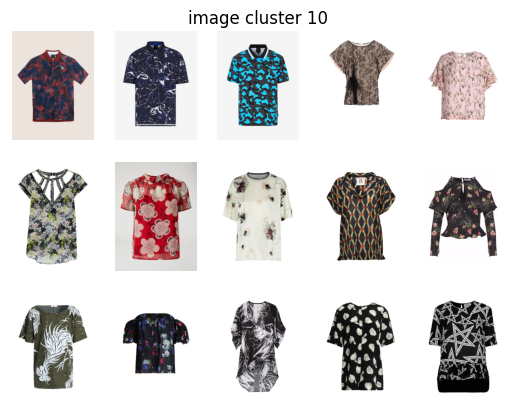

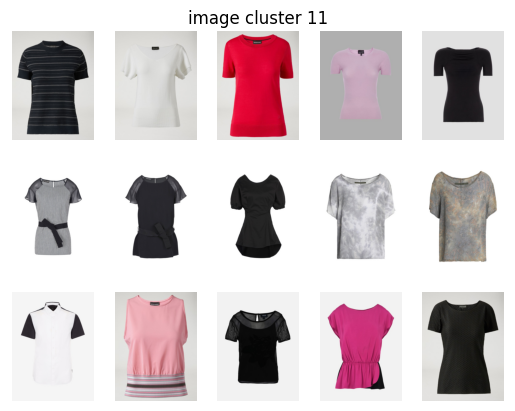

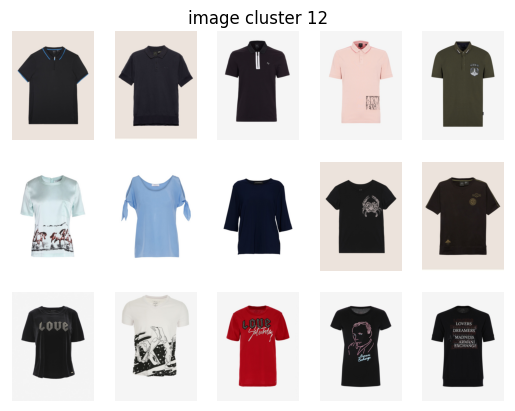

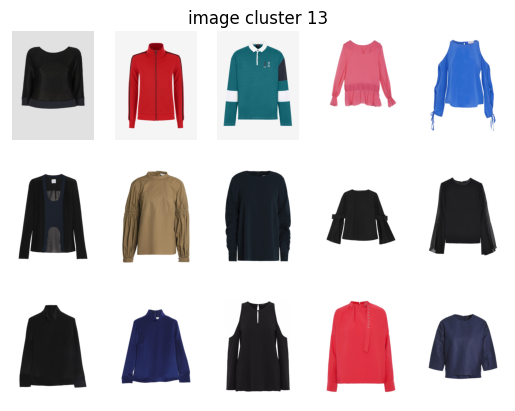

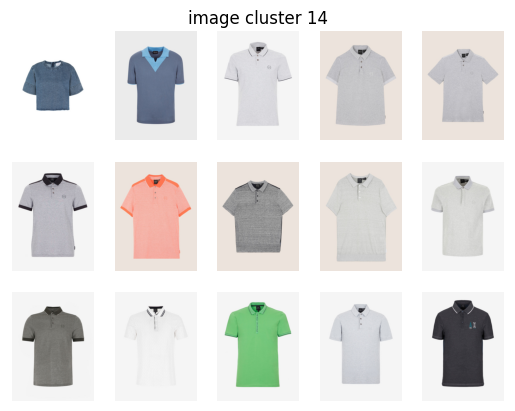

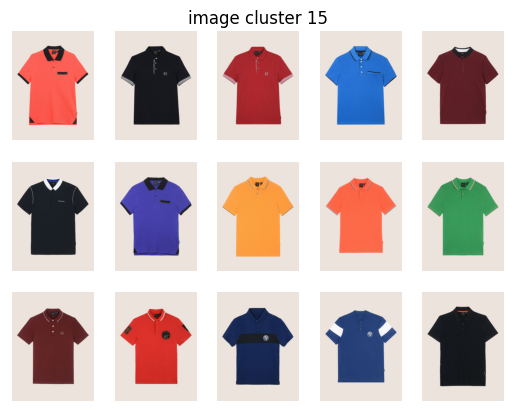

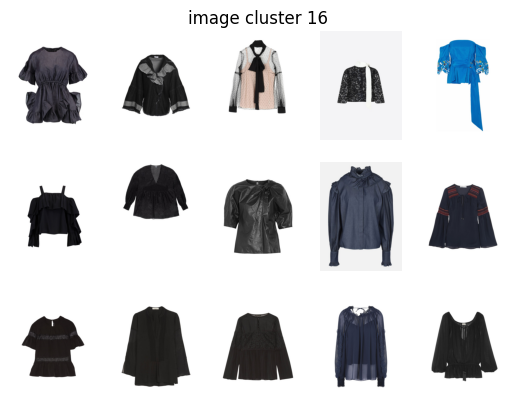

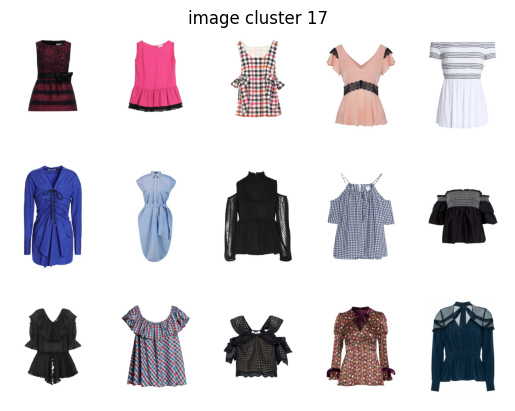

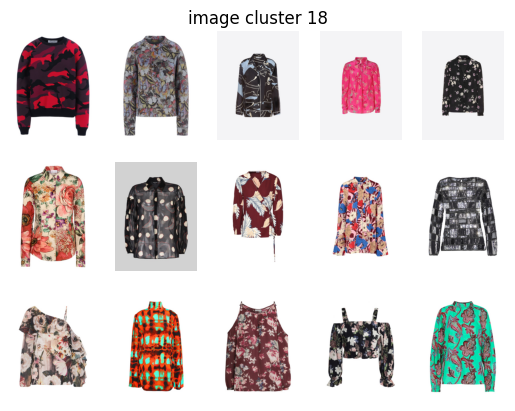

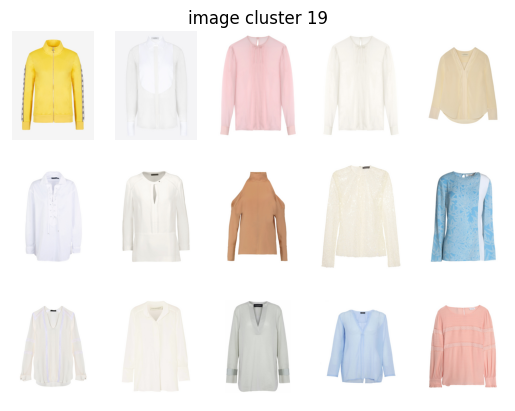

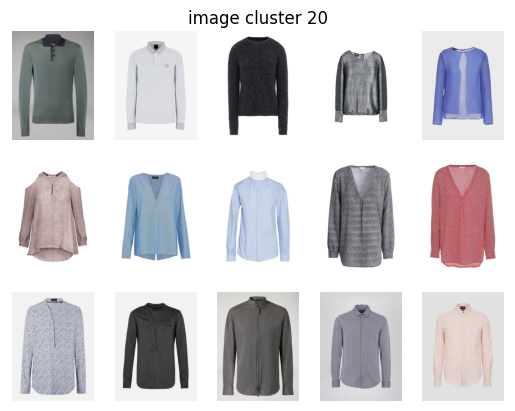

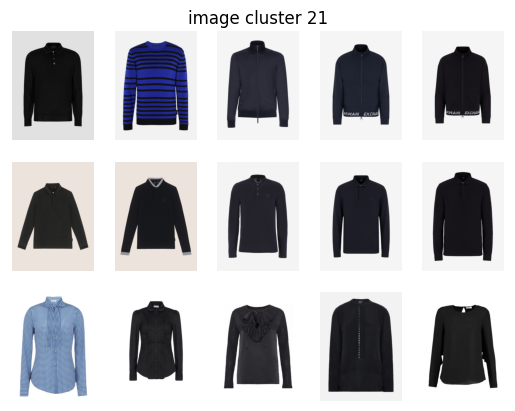

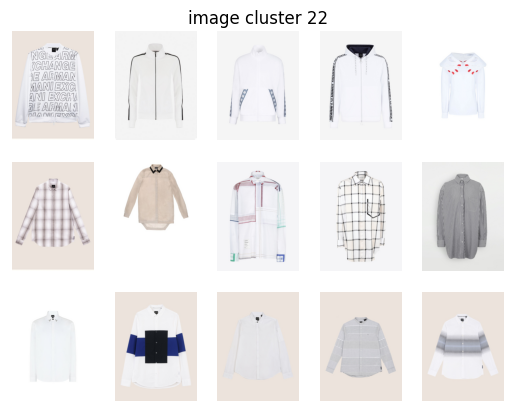

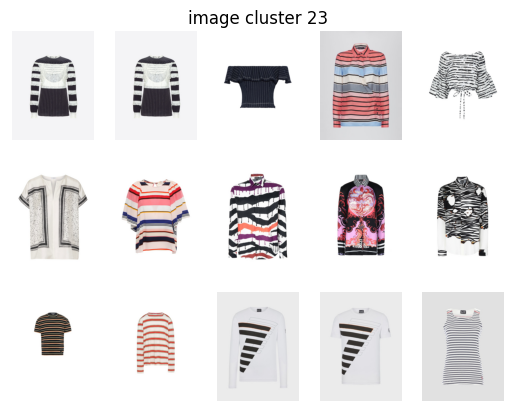

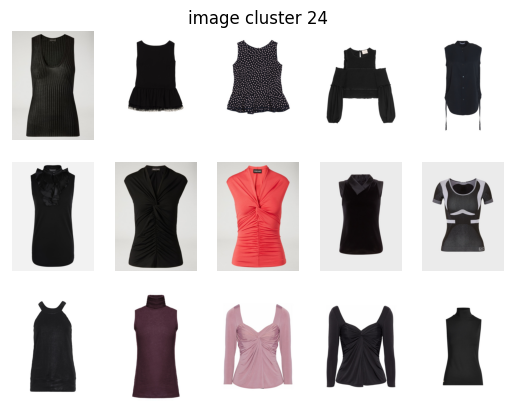

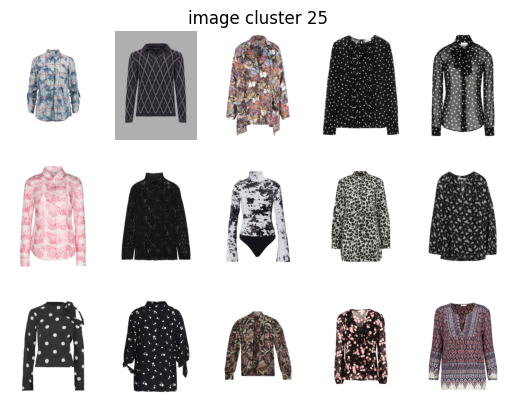

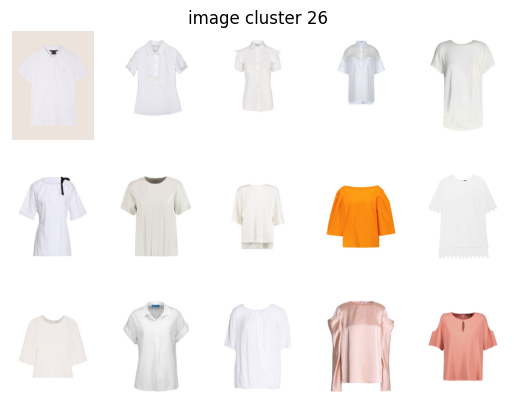

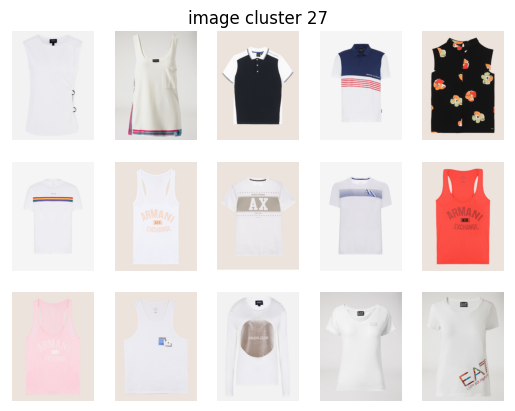

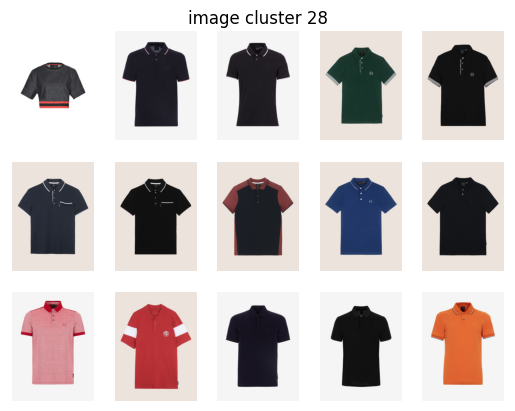

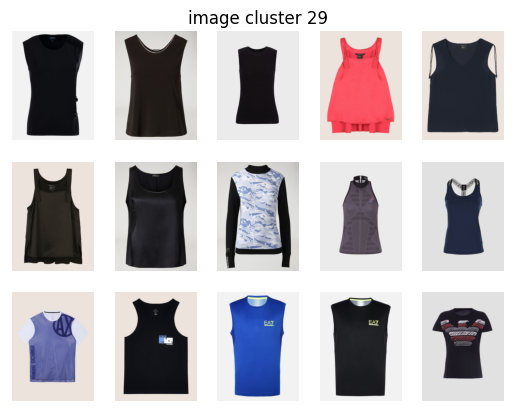

In [13]:
for i in range(30):
    plt.figure()
    plt.axis('off')
    plt.title(f'image cluster {i}')
    print_cluster_img(i)